In [1]:
# Imports
from os import makedirs
import pandas as pd
import numpy as np
from cmapPy.pandasGEXpress.parse import parse
from rdkit.Chem.AllChem import MolFromSmiles, MolToSmiles
from IPython.display import display
from matplotlib import pyplot as plt

In [2]:
# Constants
COMP_FILE = "metadata/compoundinfo_beta.txt"
GENE_FILE = "metadata/geneinfo_beta.txt"
INFO_FILE = "data/instinfo_beta.txt"
LEVEL5_FILE = "data/level5_beta_trt_cp_n720216x12328.gctx"
THRESHOLD = 4
THRESHOLD_lst = [-6, -3, 3, 6]
OUT_DIR_LST = []
OUT_DIR = f"out/th_{THRESHOLD}/"
OUT_DIR_LST.append(f"out/less_th_{THRESHOLD_lst[0]}/")
for i in range(len(THRESHOLD_lst)-1):
    OUT_DIR_LST.append(f"out/th_{THRESHOLD_lst[i]}_{THRESHOLD_lst[i+1]}/")
OUT_DIR_LST.append(f"out/bigger_th_{THRESHOLD_lst[3]}/")
# U2OS: Bone cancer line with most data (20k mols).
# HA1E: Non-cancer kidney line with the most data (5k mols).
CHOSEN_CELL_LINES = ["U2OS", "HA1E", "VCAP", "A549", "MCF7", "PC3", "A375"]
MIN_ACTIVE_PER_COL = 15

In [3]:
# Function to convert a SMILES to a canonical SMILES, or return None in case of error
def canonical_smiles(smiles):
    out = None
    try:
        out = MolToSmiles(MolFromSmiles(smiles))
    except:
        out = None

    return out

In [ ]:
# Read the compounds data. This allows to relate the perturbation identification "pert_id" to molecular SMILES
comp_df = pd.read_csv(COMP_FILE, sep="\t", index_col="pert_id", 
                    usecols=["pert_id", "canonical_smiles", "inchi_key", "compound_aliases"])
comp_df = comp_df.rename(columns={"canonical_smiles": "SMILES"})
print(comp_df.shape)
comp_df

In [26]:
# Read the genes data. This allows to find which genes are measured, and which are inferred linearily
gene_df = pd.read_csv(GENE_FILE, sep="\t", usecols=["gene_id", "feature_space"])
realgene_df = gene_df[gene_df["feature_space"] == "landmark"]
realgene_id = realgene_df["gene_id"].values
print(realgene_df.shape)
realgene_df

(978, 2)


,gene_id,feature_space
2154,16,landmark
2155,23,landmark
2156,25,landmark
2157,30,landmark
2158,39,landmark
...,...,...
3127,200081,landmark
3128,200734,landmark
3129,256364,landmark
3130,375346,landmark


In [27]:

info_df = pd.read_csv(INFO_FILE, sep="\t", usecols=["pert_mfc_id", "sample_id", "cmap_name", "cell_iname"])
info_df

,pert_mfc_id,sample_id,cell_iname,cmap_name
0,ERG_11,ERG013_VCAP_72H_X3_B11:O14,VCAP,ERG
1,TRCN0000072237,TAK004_U2OS_96H_X2_B10_DUO52HI53LO:D10,U2OS,LACZ
2,SOD3,CYT001_HEPG2_2H_X2_B12:N12,HEPG2,SOD3
3,ENTRY00543,HSF038_HEK293T_48H_X2_B12:M01,HEK293T,PDGFRA
4,BRD-K79781870,DOS043_A375_24H_X1_F3B5_DUO52HI53LO:D17,A375,BRD-K79781870
...,...,...,...,...
3026455,BRD-K07955840,AICHI002_BJAB_4H_X1.A2_B40:N04,BJAB,PF-05212384
3026456,BRD-K64606589,HDAC001_MCF7_24H_X1_F1B3_DUO52HI53LO:H10,MCF7,apicidin
3026457,BRD-K61894884,HDAC001_PC3_24H_X1_F1B3_DUO52HI53LO:N04,PC3,BRD-K61894884
3026458,BRD-K57545991,RAD001_MCF7_24H_X3_F1B5_DUO52HI53LO:L07,MCF7,enalapril


In [28]:
# Read the first column of the full Level-5 data file, and find the row indexes (ridx) corresponding to real genes
data_gene_id = parse(LEVEL5_FILE, cidx=[0]).row_metadata_df.index.values
data_gene_id = data_gene_id.astype(int)
keep_gene_ridx = [ii for ii, id in enumerate(data_gene_id) if id in realgene_id]

print(len(data_gene_id))
print(len(realgene_id))
print(len(keep_gene_ridx))

12328
978
978


In [29]:
# Read the full Level-5 data file by only taking rows with real genes
parsed = parse(LEVEL5_FILE, ridx=keep_gene_ridx)
parsed_df = parsed.data_df.transpose()
parsed_df

rid,10007,1001,10013,10038,10046,10049,10051,10057,10058,10059,...,9918,9924,9926,9928,993,994,9943,9961,998,9988
cid,,,,,,,,,,,,,,,,,,,,,
ABY001_A375_XH:BRD-A61304759:0.625:24,-1.166500,-0.606900,-0.733650,-1.481400,1.281200,4.095450,-0.712400,0.995350,-0.031650,-0.990250,...,-4.591100,-2.772350,-1.522700,0.975500,-0.533750,-1.987450,-0.883050,-1.605100,0.005250,0.979050
ABY001_A375_XH:BRD-A61304759:0.625:3,0.794862,-0.358541,0.122322,-0.550787,-0.178181,1.566406,0.058614,0.308965,0.369855,-0.948085,...,-0.737773,-1.188786,0.710014,0.212338,0.813161,-1.252179,-2.421624,-0.335863,0.308946,-0.352101
ABY001_A375_XH:BRD-A61304759:10:24,2.599445,1.755998,-0.776326,-4.121394,2.539309,0.533612,-5.299499,1.496123,0.462508,2.645836,...,-0.199841,1.496310,-1.691253,-1.129814,-3.005869,-3.355338,-0.400337,0.068793,-0.495560,0.044498
ABY001_A375_XH:BRD-A61304759:10:3,0.230140,1.530381,-0.823664,0.111742,0.497451,-1.489498,0.113403,0.309370,0.087925,-1.126528,...,0.054724,0.081189,1.334616,0.923640,0.600097,-2.425969,-2.049004,-0.486649,0.594023,1.365092
ABY001_A375_XH:BRD-A61304759:2.5:24,2.498556,3.288291,-0.831289,-3.811227,-0.816384,4.508691,-3.575771,1.432798,0.086126,1.699897,...,-1.342500,1.914565,-0.571770,-0.849444,-3.464440,-2.774929,-0.593055,-0.425393,0.606134,-1.007184
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TSAI002_NPC-8_XH:CI-994:10,1.345983,1.670408,-0.476440,-2.529742,-0.085121,-1.593576,-0.682030,-0.727800,-0.848668,-5.717160,...,1.135530,-2.435960,-1.364442,-0.471916,-3.696775,-0.480867,0.580864,-1.001272,0.734962,-2.252348
TSAI002_NPC-8_XH:COMPE:2,-1.086894,-0.097282,-0.066396,-1.676546,0.870530,-0.634537,-0.058797,3.930091,-0.814762,0.419928,...,0.081087,0.830733,0.829341,0.053908,-0.668944,-1.414609,0.347334,1.881268,0.202310,0.466976
TSAI002_NPC-8_XH:DAC-3:5,-0.172855,-0.120174,-0.810217,0.721430,0.245437,0.178710,1.026641,-0.151166,-0.043268,0.508430,...,-0.055938,-0.204528,-0.076671,-0.097271,0.548531,-0.037314,0.554130,-0.466869,0.236111,-2.094904


In [30]:
# Add the "pert_id" and "cell_iname" to the dataframe
pert_id = ["-".join(id.split(":")[1].split("-")[:2]) for id in parsed_df.index]
cell_iname = [id.split("_")[1] for id in parsed_df.index]
data_cols = list(parsed_df.columns)
parsed_df2 = parsed_df.copy(deep=True)
print(len(parsed_df2.index))
parsed_df2["full_id"] = parsed_df2.index
parsed_df2["pert_id"] = pert_id
parsed_df2["cell_iname"] = cell_iname

# Remove all rows that are not small molecules (don't contain "BRD").
# Merge with `comp_df` to get the compound information associated to each `pert_id`
# Remove all rows that don't have a valid SMILES
parsed_df2 = parsed_df2[parsed_df2["pert_id"].str.contains("BRD")]
parsed_df2 = pd.merge(parsed_df2, comp_df, on="pert_id")
is_good_smiles = np.array([isinstance(s, str) for s in parsed_df2["SMILES"]])
parsed_df2 = parsed_df2[is_good_smiles]
parsed_df2

720216


,10007,1001,10013,10038,10046,10049,10051,10057,10058,10059,...,9943,9961,998,9988,full_id,pert_id,cell_iname,SMILES,inchi_key,compound_aliases
0,-1.166500,-0.606900,-0.733650,-1.481400,1.281200,4.095450,-0.712400,0.995350,-0.031650,-0.990250,...,-0.883050,-1.605100,0.005250,0.979050,ABY001_A375_XH:BRD-A61304759:0.625:24,BRD-A61304759,A375,COC1CC(C)CC2=C(NCC=C)C(=O)C=C(NC(=O)C(C)=CC=CC...,AYUNIORJHRXIBJ-ZGQRYRSUSA-N,NaN
1,0.794862,-0.358541,0.122322,-0.550787,-0.178181,1.566406,0.058614,0.308965,0.369855,-0.948085,...,-2.421624,-0.335863,0.308946,-0.352101,ABY001_A375_XH:BRD-A61304759:0.625:3,BRD-A61304759,A375,COC1CC(C)CC2=C(NCC=C)C(=O)C=C(NC(=O)C(C)=CC=CC...,AYUNIORJHRXIBJ-ZGQRYRSUSA-N,NaN
2,2.599445,1.755998,-0.776326,-4.121394,2.539309,0.533612,-5.299499,1.496123,0.462508,2.645836,...,-0.400337,0.068793,-0.495560,0.044498,ABY001_A375_XH:BRD-A61304759:10:24,BRD-A61304759,A375,COC1CC(C)CC2=C(NCC=C)C(=O)C=C(NC(=O)C(C)=CC=CC...,AYUNIORJHRXIBJ-ZGQRYRSUSA-N,NaN
3,0.230140,1.530381,-0.823664,0.111742,0.497451,-1.489498,0.113403,0.309370,0.087925,-1.126528,...,-2.049004,-0.486649,0.594023,1.365092,ABY001_A375_XH:BRD-A61304759:10:3,BRD-A61304759,A375,COC1CC(C)CC2=C(NCC=C)C(=O)C=C(NC(=O)C(C)=CC=CC...,AYUNIORJHRXIBJ-ZGQRYRSUSA-N,NaN
4,2.498556,3.288291,-0.831289,-3.811227,-0.816384,4.508691,-3.575771,1.432798,0.086126,1.699897,...,-0.593055,-0.425393,0.606134,-1.007184,ABY001_A375_XH:BRD-A61304759:2.5:24,BRD-A61304759,A375,COC1CC(C)CC2=C(NCC=C)C(=O)C=C(NC(=O)C(C)=CC=CC...,AYUNIORJHRXIBJ-ZGQRYRSUSA-N,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
429384,0.605400,-0.179350,-0.672100,-0.628750,0.111400,0.544600,0.591700,-1.256000,0.485650,-4.867000,...,-0.829850,-0.131600,-0.814150,-0.741750,RAD001_PC3_6H:BRD-K95986273-001-01-9:0.1235,BRD-K95986273,PC3,Cc1nc2ccccc2n1N=Cc1ccc(s1)[N+]([O-])=O,RBCPBVNYTIFDIR-RIYZIHGNSA-N,NaN
429385,0.160400,0.277550,-0.141750,1.081850,-0.488050,0.783200,-0.577050,-0.049500,-0.270950,0.489950,...,-1.115850,0.279050,-0.244850,-0.436050,RAD001_PC3_6H:BRD-K95986273-001-01-9:0.3704,BRD-K95986273,PC3,Cc1nc2ccccc2n1N=Cc1ccc(s1)[N+]([O-])=O,RBCPBVNYTIFDIR-RIYZIHGNSA-N,NaN
429386,0.400950,0.139500,1.385550,-3.053850,5.312200,0.763750,-1.333150,0.471400,-0.385800,0.401000,...,-0.331250,0.954800,0.373200,-0.479750,RAD001_PC3_6H:BRD-K95986273-001-01-9:1.1111,BRD-K95986273,PC3,Cc1nc2ccccc2n1N=Cc1ccc(s1)[N+]([O-])=O,RBCPBVNYTIFDIR-RIYZIHGNSA-N,NaN
429387,0.721800,0.454000,0.146150,-1.052350,0.394500,0.732550,-1.404100,0.240850,-0.753750,1.155500,...,-0.236550,0.410850,0.219400,-0.355300,RAD001_PC3_6H:BRD-K95986273-001-01-9:10,BRD-K95986273,PC3,Cc1nc2ccccc2n1N=Cc1ccc(s1)[N+]([O-])=O,RBCPBVNYTIFDIR-RIYZIHGNSA-N,NaN


In [31]:
# Find the 20 cell lines with the most unique molecules data points, and print them
cols_merge_by = ["pert_id", "cell_iname"]
cols_other = list(set(parsed_df2.columns) - set(cols_merge_by))
agg_dict = {col: "mean" if col in data_cols else "first" for col in cols_other}
grouped_by_cell_mol = parsed_df2.groupby(by=cols_merge_by, axis=0, as_index=False).agg(agg_dict)
print("top 20 cell lines, number of unique molecules:")
top20_lines = grouped_by_cell_mol["cell_iname"].value_counts()[:20]
top20_lines

top 20 cell lines, number of unique molecules:


U2OS        16058
VCAP        15220
A549        12285
MCF7        11622
PC3         11521
A375        10694
HT29        10078
HA1E         5514
HCC515       5351
HEPG2        4585
NPC          3481
NEU          2508
ASC          2443
SKB          2434
PHH          1851
FIBRNPC       611
U937          399
NCIH2073      368
NCIH596       368
NCIH508       367
Name: cell_iname, dtype: int64

In [32]:
# Split into different dataframes per cell line in `CHOSEN_CELL_LINES`
df_per_cell_line = {}
for line in CHOSEN_CELL_LINES:
    df_per_cell_line[line] = parsed_df2[parsed_df2["cell_iname"] == line]
    print(line)
    display(df_per_cell_line[line])

U2OS


,10007,1001,10013,10038,10046,10049,10051,10057,10058,10059,...,9943,9961,998,9988,full_id,pert_id,cell_iname,SMILES,inchi_key,compound_aliases
354,0.266000,-0.479600,-0.198300,-0.431300,-1.229350,3.355450,-1.548500,0.493650,-0.611050,0.528150,...,0.097050,-2.536850,-1.160750,0.172700,PAC001_U2OS_6H:BRD-A61304759-001-01-0:20,BRD-A61304759,U2OS,COC1CC(C)CC2=C(NCC=C)C(=O)C=C(NC(=O)C(C)=CC=CC...,AYUNIORJHRXIBJ-ZGQRYRSUSA-N,NaN
355,0.215200,0.210250,1.565950,-0.410100,-0.532450,3.426700,-0.762800,1.400200,0.557150,-0.067150,...,1.420500,-1.600900,-0.944150,0.896000,PAC002_U2OS_6H:BRD-A61304759-001-01-0:20,BRD-A61304759,U2OS,COC1CC(C)CC2=C(NCC=C)C(=O)C=C(NC(=O)C(C)=CC=CC...,AYUNIORJHRXIBJ-ZGQRYRSUSA-N,NaN
356,-0.030250,0.215500,1.020750,0.212600,0.240450,2.905800,-1.067600,0.687250,0.232700,0.448650,...,-0.074000,-1.339700,-0.656750,-0.375600,PAC003_U2OS_6H:BRD-A61304759-001-01-0:20,BRD-A61304759,U2OS,COC1CC(C)CC2=C(NCC=C)C(=O)C=C(NC(=O)C(C)=CC=CC...,AYUNIORJHRXIBJ-ZGQRYRSUSA-N,NaN
357,0.131900,1.166850,1.117750,-0.466700,-0.843450,4.599200,-2.009750,-0.575650,0.672100,0.367900,...,0.687200,-1.443900,-1.615750,-0.186750,PAC004_U2OS_6H:BRD-A61304759-001-01-0:20,BRD-A61304759,U2OS,COC1CC(C)CC2=C(NCC=C)C(=O)C=C(NC(=O)C(C)=CC=CC...,AYUNIORJHRXIBJ-ZGQRYRSUSA-N,NaN
358,-0.034000,0.874000,0.655750,-0.269150,0.966950,3.022300,-0.939900,0.985750,0.717850,-0.352600,...,-1.305050,-1.605700,-2.667600,-0.660750,PAC005_U2OS_6H:BRD-A61304759-001-01-0:20,BRD-A61304759,U2OS,COC1CC(C)CC2=C(NCC=C)C(=O)C=C(NC(=O)C(C)=CC=CC...,AYUNIORJHRXIBJ-ZGQRYRSUSA-N,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
423912,-0.517706,-1.212317,-0.322461,0.124004,-0.497949,0.409649,1.260086,0.022732,-0.279040,0.357222,...,1.349653,1.112821,-0.600327,-0.213830,PAC068_U2OS_6H:BRD-K77801455-001-05-3:10,BRD-K77801455,U2OS,CCC(=O)NCC(=O)OCC(=O)c1ccccc1,NaN,Propionylamino-acetic acid 2-oxo-2-phenyl-ethy...
423922,0.404553,-0.282865,0.209292,0.007066,0.490206,-0.355228,-0.748379,0.106611,-0.473985,-0.632465,...,0.196296,-0.104630,0.070716,-0.157745,PAC068_U2OS_6H:BRD-K81266242-001-05-1:10,BRD-K81266242,U2OS,O=C(CCc1ccccc1)N1CCN(CC1)c1ccccn1,NaN,1-(3-phenylpropanoyl)-4-(2-pyridinyl)piperazine
423925,-0.451088,0.057352,-0.274881,-0.319326,-0.444744,0.394264,0.334506,-0.001001,-0.517647,-0.022595,...,0.168200,1.282395,0.302800,-0.405775,PAC068_U2OS_6H:BRD-K83028309-001-05-3:10,BRD-K83028309,U2OS,Nc1cc(nc2cc(nn12)-c1ccccc1)-c1ccc(Br)cc1,NaN,"5-(4-Bromo-phenyl)-2-phenyl-pyrazolo[1,5-a]pyr..."
423939,-1.002630,0.584975,0.709276,0.607589,0.158020,-1.167863,0.213422,-0.155531,0.696174,-0.907303,...,0.025072,0.210780,-0.037277,-0.869588,PAC068_U2OS_6H:BRD-K87879912-001-05-4:10,BRD-K87879912,U2OS,O=S(=O)(CCOc1ccccc1)c1nc2ccccc2[nH]1,NaN,NaN


HA1E


,10007,1001,10013,10038,10046,10049,10051,10057,10058,10059,...,9943,9961,998,9988,full_id,pert_id,cell_iname,SMILES,inchi_key,compound_aliases
106,-3.013548,0.849998,-0.471952,-4.127614,1.278855,3.154837,1.450641,1.296630,-0.429045,0.139617,...,-2.103442,-4.727867,-1.920775,-0.160905,DOSVAL002_HA1E_24H:BRD-A61304759:10,BRD-A61304759,HA1E,COC1CC(C)CC2=C(NCC=C)C(=O)C=C(NC(=O)C(C)=CC=CC...,AYUNIORJHRXIBJ-ZGQRYRSUSA-N,NaN
107,-0.923984,0.169660,0.154486,-1.153042,-0.351350,2.678426,2.441816,1.726164,-0.662480,0.971808,...,-1.590330,-4.548966,-1.674109,-2.167018,DOSVAL002_HA1E_24H:BRD-A61304759:20,BRD-A61304759,HA1E,COC1CC(C)CC2=C(NCC=C)C(=O)C=C(NC(=O)C(C)=CC=CC...,AYUNIORJHRXIBJ-ZGQRYRSUSA-N,NaN
108,-2.871151,1.047984,-1.013709,-2.247387,-0.014152,2.040751,2.078447,0.631643,-1.353293,1.209673,...,-2.080195,-3.855181,-2.286743,-1.489498,DOSVAL002_HA1E_24H:BRD-A61304759:5,BRD-A61304759,HA1E,COC1CC(C)CC2=C(NCC=C)C(=O)C=C(NC(=O)C(C)=CC=CC...,AYUNIORJHRXIBJ-ZGQRYRSUSA-N,NaN
130,-1.602455,0.846125,-0.184822,-3.970871,6.530649,0.050334,2.001070,7.324931,-0.659349,-10.000000,...,-2.898046,-6.817307,-3.343323,-1.189793,DOSVAL003_HA1E_24H:BRD-A61304759:10,BRD-A61304759,HA1E,COC1CC(C)CC2=C(NCC=C)C(=O)C=C(NC(=O)C(C)=CC=CC...,AYUNIORJHRXIBJ-ZGQRYRSUSA-N,NaN
131,1.147850,0.468300,3.880000,0.008400,-0.811200,3.177950,2.405700,2.352800,-1.297900,0.873900,...,-2.477500,-7.021399,-1.506050,-2.879350,DOSVAL003_HA1E_24H:BRD-A61304759:20,BRD-A61304759,HA1E,COC1CC(C)CC2=C(NCC=C)C(=O)C=C(NC(=O)C(C)=CC=CC...,AYUNIORJHRXIBJ-ZGQRYRSUSA-N,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
428533,-0.260942,-1.251015,0.363250,-1.018164,0.953256,-0.653346,0.526826,-0.318230,0.755271,-0.339214,...,0.248439,0.307065,-0.885660,-0.235281,PCLB003_HA1E_24H:BRD-K83493571-001-02-7:0.12,BRD-K83493571,HA1E,C[C@@H]1CC(=O)NN=C1c1ccc(I)cc1,XWOMTTOIGDQNSS-SSDOTTSWSA-N,NaN
428534,-0.947571,1.256580,-0.693020,-0.355582,0.079166,0.242886,-0.026739,-0.611576,-0.457813,-0.756950,...,-0.364928,0.388835,-0.503934,-1.223861,PCLB003_HA1E_24H:BRD-K83493571-001-02-7:0.37,BRD-K83493571,HA1E,C[C@@H]1CC(=O)NN=C1c1ccc(I)cc1,XWOMTTOIGDQNSS-SSDOTTSWSA-N,NaN
428535,-0.525437,-0.199946,-0.405681,-0.694295,0.153188,-1.539271,0.260968,0.276569,0.027623,0.204523,...,0.416565,0.177532,0.545663,0.016072,PCLB003_HA1E_24H:BRD-K83493571-001-02-7:1.11,BRD-K83493571,HA1E,C[C@@H]1CC(=O)NN=C1c1ccc(I)cc1,XWOMTTOIGDQNSS-SSDOTTSWSA-N,NaN
428536,1.317981,0.104952,1.105384,0.492846,0.249595,-0.191166,0.863211,-0.026311,-1.277453,-0.335337,...,0.916682,-0.907757,0.268371,0.144862,PCLB003_HA1E_24H:BRD-K83493571-001-02-7:10,BRD-K83493571,HA1E,C[C@@H]1CC(=O)NN=C1c1ccc(I)cc1,XWOMTTOIGDQNSS-SSDOTTSWSA-N,NaN


VCAP


,10007,1001,10013,10038,10046,10049,10051,10057,10058,10059,...,9943,9961,998,9988,full_id,pert_id,cell_iname,SMILES,inchi_key,compound_aliases
220,0.342880,0.229699,0.662968,0.112721,0.031991,0.223551,-0.312346,0.603852,0.173999,-0.088876,...,-0.354263,-0.067259,0.125386,-0.309967,ERG005_VCAP_24H:BRD-A61304759-001-01-0:1,BRD-A61304759,VCAP,COC1CC(C)CC2=C(NCC=C)C(=O)C=C(NC(=O)C(C)=CC=CC...,AYUNIORJHRXIBJ-ZGQRYRSUSA-N,NaN
221,-1.243966,0.884699,0.361250,-0.877446,0.137078,1.132378,-0.255957,1.240245,-1.849554,0.469157,...,-0.528902,0.165169,-2.121547,-0.109978,ERG005_VCAP_24H:BRD-A61304759-001-01-0:20,BRD-A61304759,VCAP,COC1CC(C)CC2=C(NCC=C)C(=O)C=C(NC(=O)C(C)=CC=CC...,AYUNIORJHRXIBJ-ZGQRYRSUSA-N,NaN
222,0.054080,0.722968,1.164083,-0.604267,0.272366,0.123806,-0.787444,-0.049253,-0.339428,-0.474537,...,-0.271633,0.196106,0.786506,-0.593048,ERG005_VCAP_24H:BRD-A61304759-001-01-0:5,BRD-A61304759,VCAP,COC1CC(C)CC2=C(NCC=C)C(=O)C=C(NC(=O)C(C)=CC=CC...,AYUNIORJHRXIBJ-ZGQRYRSUSA-N,NaN
223,1.446668,-0.646172,0.734950,-0.025302,-0.581938,0.221347,-0.812867,0.183442,0.291759,0.328828,...,0.038288,-0.052247,1.144971,0.232041,ERG005_VCAP_48H:BRD-A61304759-001-01-0:1,BRD-A61304759,VCAP,COC1CC(C)CC2=C(NCC=C)C(=O)C=C(NC(=O)C(C)=CC=CC...,AYUNIORJHRXIBJ-ZGQRYRSUSA-N,NaN
224,-1.647826,0.715185,-1.479616,-2.191869,0.867779,1.617837,-3.098122,0.713327,-5.324870,-0.913241,...,-1.650342,0.283260,-0.322341,-0.007010,ERG005_VCAP_48H:BRD-A61304759-001-01-0:20,BRD-A61304759,VCAP,COC1CC(C)CC2=C(NCC=C)C(=O)C=C(NC(=O)C(C)=CC=CC...,AYUNIORJHRXIBJ-ZGQRYRSUSA-N,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
392266,-0.192500,0.508600,2.958000,-1.932200,0.625200,4.463600,-2.164600,2.193400,-8.490000,1.876900,...,2.317700,0.059300,0.172300,0.411000,ERG021_VCAP_24H:BRD-K54606188:0.37,BRD-K54606188,VCAP,Cc1sc-2c(c1C)C(=N[C@@H](CC(=O)OC(C)(C)C)c1nnc(...,DNVXATUJJDPFDM-KRWDZBQOSA-N,JQ1-(+)
392267,0.062300,2.650200,4.473000,-2.151800,1.434600,4.882200,-2.347200,0.762400,-7.368100,2.178000,...,2.935600,-1.046000,0.059300,1.767200,ERG021_VCAP_24H:BRD-K54606188:1.11,BRD-K54606188,VCAP,Cc1sc-2c(c1C)C(=N[C@@H](CC(=O)OC(C)(C)C)c1nnc(...,DNVXATUJJDPFDM-KRWDZBQOSA-N,JQ1-(+)
392268,-2.960600,5.703700,-1.779000,-2.988500,0.603800,3.217200,-6.156700,1.033800,0.648600,-1.277400,...,1.282700,-0.674500,-2.119500,1.252500,ERG021_VCAP_24H:BRD-K54606188:10,BRD-K54606188,VCAP,Cc1sc-2c(c1C)C(=N[C@@H](CC(=O)OC(C)(C)C)c1nnc(...,DNVXATUJJDPFDM-KRWDZBQOSA-N,JQ1-(+)
392269,1.223100,2.595200,4.695200,-10.000000,10.000000,4.339800,-2.816400,-0.030300,-7.763000,2.217900,...,4.241800,2.065300,-0.366800,1.030100,ERG021_VCAP_24H:BRD-K54606188:3.33,BRD-K54606188,VCAP,Cc1sc-2c(c1C)C(=N[C@@H](CC(=O)OC(C)(C)C)c1nnc(...,DNVXATUJJDPFDM-KRWDZBQOSA-N,JQ1-(+)


A549


,10007,1001,10013,10038,10046,10049,10051,10057,10058,10059,...,9943,9961,998,9988,full_id,pert_id,cell_iname,SMILES,inchi_key,compound_aliases
6,0.267136,-0.456491,2.165093,0.229504,-0.124224,1.576591,-1.828272,-0.225401,1.707536,-0.433627,...,-0.181523,-1.382612,-1.131088,1.328648,ABY001_A549_XH:BRD-A61304759:0.625:24,BRD-A61304759,A549,COC1CC(C)CC2=C(NCC=C)C(=O)C=C(NC(=O)C(C)=CC=CC...,AYUNIORJHRXIBJ-ZGQRYRSUSA-N,NaN
7,-0.324586,0.342067,0.473313,-1.177638,0.367503,0.820698,0.339237,0.549441,0.062816,-1.037903,...,-0.805294,-0.009581,-0.667608,-1.633135,ABY001_A549_XH:BRD-A61304759:0.625:3,BRD-A61304759,A549,COC1CC(C)CC2=C(NCC=C)C(=O)C=C(NC(=O)C(C)=CC=CC...,AYUNIORJHRXIBJ-ZGQRYRSUSA-N,NaN
8,-0.117392,0.200503,3.915682,0.172298,-0.620917,1.896570,-0.351663,2.388200,2.241555,0.882148,...,-0.274837,-2.573916,-1.041967,0.582418,ABY001_A549_XH:BRD-A61304759:10:24,BRD-A61304759,A549,COC1CC(C)CC2=C(NCC=C)C(=O)C=C(NC(=O)C(C)=CC=CC...,AYUNIORJHRXIBJ-ZGQRYRSUSA-N,NaN
9,-0.735243,0.217042,-0.535154,-0.395466,4.530125,0.816603,0.998695,0.983210,0.226104,0.306891,...,-1.253998,-0.720851,-0.501165,-1.326902,ABY001_A549_XH:BRD-A61304759:10:3,BRD-A61304759,A549,COC1CC(C)CC2=C(NCC=C)C(=O)C=C(NC(=O)C(C)=CC=CC...,AYUNIORJHRXIBJ-ZGQRYRSUSA-N,NaN
10,0.703145,-0.459059,2.882389,-0.590942,-0.809936,1.652521,-1.464148,1.901619,1.833337,-0.166399,...,-0.108275,-3.197631,0.172597,0.360270,ABY001_A549_XH:BRD-A61304759:2.5:24,BRD-A61304759,A549,COC1CC(C)CC2=C(NCC=C)C(=O)C=C(NC(=O)C(C)=CC=CC...,AYUNIORJHRXIBJ-ZGQRYRSUSA-N,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
429339,-0.160872,-0.734598,1.037349,0.409271,0.470073,-1.236599,0.196407,-0.355948,-0.174792,-0.057376,...,0.337520,0.789028,0.747753,-0.793304,RAD001_A549_6H:BRD-K95986273-001-01-9:0.1235,BRD-K95986273,A549,Cc1nc2ccccc2n1N=Cc1ccc(s1)[N+]([O-])=O,RBCPBVNYTIFDIR-RIYZIHGNSA-N,NaN
429340,-0.732872,1.154789,-0.203751,-3.644891,-0.587741,-0.480639,0.555011,-0.190167,0.048464,0.048362,...,-0.742586,0.149100,0.208475,1.110267,RAD001_A549_6H:BRD-K95986273-001-01-9:0.3704,BRD-K95986273,A549,Cc1nc2ccccc2n1N=Cc1ccc(s1)[N+]([O-])=O,RBCPBVNYTIFDIR-RIYZIHGNSA-N,NaN
429341,0.777660,-1.287675,1.083690,0.470522,-0.752226,0.692116,0.607769,-0.312699,0.636528,-0.097325,...,0.280083,0.451212,0.341323,-1.047601,RAD001_A549_6H:BRD-K95986273-001-01-9:1.1111,BRD-K95986273,A549,Cc1nc2ccccc2n1N=Cc1ccc(s1)[N+]([O-])=O,RBCPBVNYTIFDIR-RIYZIHGNSA-N,NaN
429342,-1.804538,1.066838,-1.099731,-4.657009,0.519173,1.021468,-1.191034,-0.361392,-0.004369,0.618981,...,-1.331334,-0.257574,-0.680384,0.707249,RAD001_A549_6H:BRD-K95986273-001-01-9:10,BRD-K95986273,A549,Cc1nc2ccccc2n1N=Cc1ccc(s1)[N+]([O-])=O,RBCPBVNYTIFDIR-RIYZIHGNSA-N,NaN


MCF7


,10007,1001,10013,10038,10046,10049,10051,10057,10058,10059,...,9943,9961,998,9988,full_id,pert_id,cell_iname,SMILES,inchi_key,compound_aliases
118,-0.151476,0.621351,2.347261,-3.394480,0.705109,3.007318,-1.392812,1.340819,-0.493219,0.226146,...,1.995036,2.507559,-0.663364,0.389883,DOSVAL002_MCF7_24H:BRD-A61304759:10,BRD-A61304759,MCF7,COC1CC(C)CC2=C(NCC=C)C(=O)C=C(NC(=O)C(C)=CC=CC...,AYUNIORJHRXIBJ-ZGQRYRSUSA-N,NaN
119,1.237476,3.581586,1.872769,-2.050381,3.755759,1.854455,-1.684269,1.683576,-1.984033,-0.013219,...,1.744408,1.580303,-1.773016,-0.429320,DOSVAL002_MCF7_24H:BRD-A61304759:20,BRD-A61304759,MCF7,COC1CC(C)CC2=C(NCC=C)C(=O)C=C(NC(=O)C(C)=CC=CC...,AYUNIORJHRXIBJ-ZGQRYRSUSA-N,NaN
120,0.109900,-2.607200,-0.529500,-3.435650,0.337200,2.949850,-1.325150,1.797250,-1.341850,-5.448550,...,0.018150,0.543850,-0.603250,-0.402750,DOSVAL002_MCF7_24H:BRD-A61304759:5,BRD-A61304759,MCF7,COC1CC(C)CC2=C(NCC=C)C(=O)C=C(NC(=O)C(C)=CC=CC...,AYUNIORJHRXIBJ-ZGQRYRSUSA-N,NaN
142,1.547964,3.207467,4.032832,-5.399337,3.068183,7.430446,-1.348630,2.029970,-2.210826,-3.993357,...,0.389575,1.363373,-1.417060,-2.060568,DOSVAL003_MCF7_24H:BRD-A61304759:10,BRD-A61304759,MCF7,COC1CC(C)CC2=C(NCC=C)C(=O)C=C(NC(=O)C(C)=CC=CC...,AYUNIORJHRXIBJ-ZGQRYRSUSA-N,NaN
143,2.426345,3.543426,2.950618,-3.654894,2.748431,7.618900,-1.326657,2.542947,-1.990267,-0.078416,...,-0.912753,1.904016,-0.254895,-0.477555,DOSVAL003_MCF7_24H:BRD-A61304759:20,BRD-A61304759,MCF7,COC1CC(C)CC2=C(NCC=C)C(=O)C=C(NC(=O)C(C)=CC=CC...,AYUNIORJHRXIBJ-ZGQRYRSUSA-N,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
429366,0.336000,-0.053700,1.909550,0.475500,0.467850,-0.579900,-1.290500,1.730400,-0.820750,-0.195550,...,0.468450,0.488400,-0.301500,0.283500,RAD001_MCF7_6H:BRD-K95986273-001-01-9:0.1235,BRD-K95986273,MCF7,Cc1nc2ccccc2n1N=Cc1ccc(s1)[N+]([O-])=O,RBCPBVNYTIFDIR-RIYZIHGNSA-N,NaN
429367,-1.852700,0.868050,-1.025050,-1.688300,0.241750,1.051900,-0.838650,0.863800,-0.495850,0.691850,...,-3.095350,0.715700,0.848050,2.662850,RAD001_MCF7_6H:BRD-K95986273-001-01-9:0.3704,BRD-K95986273,MCF7,Cc1nc2ccccc2n1N=Cc1ccc(s1)[N+]([O-])=O,RBCPBVNYTIFDIR-RIYZIHGNSA-N,NaN
429368,-0.207700,-1.787300,0.709050,0.779100,1.664750,-0.175200,-1.194150,1.242800,1.852100,-0.948950,...,1.501750,-1.127150,2.060150,0.049900,RAD001_MCF7_6H:BRD-K95986273-001-01-9:1.1111,BRD-K95986273,MCF7,Cc1nc2ccccc2n1N=Cc1ccc(s1)[N+]([O-])=O,RBCPBVNYTIFDIR-RIYZIHGNSA-N,NaN
429369,-0.002700,-0.621450,-0.344900,-0.138900,-0.752350,1.163100,-1.199750,1.737650,1.823350,-5.000000,...,-4.205700,-0.281300,-0.412050,1.203800,RAD001_MCF7_6H:BRD-K95986273-001-01-9:10,BRD-K95986273,MCF7,Cc1nc2ccccc2n1N=Cc1ccc(s1)[N+]([O-])=O,RBCPBVNYTIFDIR-RIYZIHGNSA-N,NaN


PC3


,10007,1001,10013,10038,10046,10049,10051,10057,10058,10059,...,9943,9961,998,9988,full_id,pert_id,cell_iname,SMILES,inchi_key,compound_aliases
54,1.132950,0.123550,-3.740800,-0.016550,10.000000,-3.262950,-1.161100,2.449150,-0.093950,1.196950,...,-0.914450,-0.257750,0.881500,-1.070300,ABY001_PC3_XH:BRD-A61304759:0.625:24,BRD-A61304759,PC3,COC1CC(C)CC2=C(NCC=C)C(=O)C=C(NC(=O)C(C)=CC=CC...,AYUNIORJHRXIBJ-ZGQRYRSUSA-N,NaN
55,0.647987,-0.216487,0.400504,-0.625137,0.584906,-0.928926,-0.301941,-0.812206,0.153869,-0.414961,...,-2.728474,0.341705,1.250524,0.415484,ABY001_PC3_XH:BRD-A61304759:0.625:3,BRD-A61304759,PC3,COC1CC(C)CC2=C(NCC=C)C(=O)C=C(NC(=O)C(C)=CC=CC...,AYUNIORJHRXIBJ-ZGQRYRSUSA-N,NaN
56,1.528193,-1.074302,-1.323786,-0.371677,2.599559,1.951470,-1.349102,1.918611,-0.246618,1.007504,...,-0.715374,0.830848,-0.373370,0.462187,ABY001_PC3_XH:BRD-A61304759:10:24,BRD-A61304759,PC3,COC1CC(C)CC2=C(NCC=C)C(=O)C=C(NC(=O)C(C)=CC=CC...,AYUNIORJHRXIBJ-ZGQRYRSUSA-N,NaN
57,-0.121456,-0.782534,-1.036697,-3.055483,0.268898,1.331479,-0.922628,-0.598186,-0.808855,-2.345565,...,-0.017446,2.098738,-1.825348,0.044387,ABY001_PC3_XH:BRD-A61304759:10:3,BRD-A61304759,PC3,COC1CC(C)CC2=C(NCC=C)C(=O)C=C(NC(=O)C(C)=CC=CC...,AYUNIORJHRXIBJ-ZGQRYRSUSA-N,NaN
58,1.209288,0.214489,-2.202977,-0.599925,2.654822,2.009625,-0.924628,1.924302,-0.218531,0.153803,...,-1.776036,-0.103730,-0.251273,-1.010999,ABY001_PC3_XH:BRD-A61304759:2.5:24,BRD-A61304759,PC3,COC1CC(C)CC2=C(NCC=C)C(=O)C=C(NC(=O)C(C)=CC=CC...,AYUNIORJHRXIBJ-ZGQRYRSUSA-N,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
429384,0.605400,-0.179350,-0.672100,-0.628750,0.111400,0.544600,0.591700,-1.256000,0.485650,-4.867000,...,-0.829850,-0.131600,-0.814150,-0.741750,RAD001_PC3_6H:BRD-K95986273-001-01-9:0.1235,BRD-K95986273,PC3,Cc1nc2ccccc2n1N=Cc1ccc(s1)[N+]([O-])=O,RBCPBVNYTIFDIR-RIYZIHGNSA-N,NaN
429385,0.160400,0.277550,-0.141750,1.081850,-0.488050,0.783200,-0.577050,-0.049500,-0.270950,0.489950,...,-1.115850,0.279050,-0.244850,-0.436050,RAD001_PC3_6H:BRD-K95986273-001-01-9:0.3704,BRD-K95986273,PC3,Cc1nc2ccccc2n1N=Cc1ccc(s1)[N+]([O-])=O,RBCPBVNYTIFDIR-RIYZIHGNSA-N,NaN
429386,0.400950,0.139500,1.385550,-3.053850,5.312200,0.763750,-1.333150,0.471400,-0.385800,0.401000,...,-0.331250,0.954800,0.373200,-0.479750,RAD001_PC3_6H:BRD-K95986273-001-01-9:1.1111,BRD-K95986273,PC3,Cc1nc2ccccc2n1N=Cc1ccc(s1)[N+]([O-])=O,RBCPBVNYTIFDIR-RIYZIHGNSA-N,NaN
429387,0.721800,0.454000,0.146150,-1.052350,0.394500,0.732550,-1.404100,0.240850,-0.753750,1.155500,...,-0.236550,0.410850,0.219400,-0.355300,RAD001_PC3_6H:BRD-K95986273-001-01-9:10,BRD-K95986273,PC3,Cc1nc2ccccc2n1N=Cc1ccc(s1)[N+]([O-])=O,RBCPBVNYTIFDIR-RIYZIHGNSA-N,NaN


A375


,10007,1001,10013,10038,10046,10049,10051,10057,10058,10059,...,9943,9961,998,9988,full_id,pert_id,cell_iname,SMILES,inchi_key,compound_aliases
0,-1.166500,-0.606900,-0.733650,-1.481400,1.281200,4.095450,-0.712400,0.995350,-0.031650,-0.990250,...,-0.883050,-1.605100,0.005250,0.979050,ABY001_A375_XH:BRD-A61304759:0.625:24,BRD-A61304759,A375,COC1CC(C)CC2=C(NCC=C)C(=O)C=C(NC(=O)C(C)=CC=CC...,AYUNIORJHRXIBJ-ZGQRYRSUSA-N,NaN
1,0.794862,-0.358541,0.122322,-0.550787,-0.178181,1.566406,0.058614,0.308965,0.369855,-0.948085,...,-2.421624,-0.335863,0.308946,-0.352101,ABY001_A375_XH:BRD-A61304759:0.625:3,BRD-A61304759,A375,COC1CC(C)CC2=C(NCC=C)C(=O)C=C(NC(=O)C(C)=CC=CC...,AYUNIORJHRXIBJ-ZGQRYRSUSA-N,NaN
2,2.599445,1.755998,-0.776326,-4.121394,2.539309,0.533612,-5.299499,1.496123,0.462508,2.645836,...,-0.400337,0.068793,-0.495560,0.044498,ABY001_A375_XH:BRD-A61304759:10:24,BRD-A61304759,A375,COC1CC(C)CC2=C(NCC=C)C(=O)C=C(NC(=O)C(C)=CC=CC...,AYUNIORJHRXIBJ-ZGQRYRSUSA-N,NaN
3,0.230140,1.530381,-0.823664,0.111742,0.497451,-1.489498,0.113403,0.309370,0.087925,-1.126528,...,-2.049004,-0.486649,0.594023,1.365092,ABY001_A375_XH:BRD-A61304759:10:3,BRD-A61304759,A375,COC1CC(C)CC2=C(NCC=C)C(=O)C=C(NC(=O)C(C)=CC=CC...,AYUNIORJHRXIBJ-ZGQRYRSUSA-N,NaN
4,2.498556,3.288291,-0.831289,-3.811227,-0.816384,4.508691,-3.575771,1.432798,0.086126,1.699897,...,-0.593055,-0.425393,0.606134,-1.007184,ABY001_A375_XH:BRD-A61304759:2.5:24,BRD-A61304759,A375,COC1CC(C)CC2=C(NCC=C)C(=O)C=C(NC(=O)C(C)=CC=CC...,AYUNIORJHRXIBJ-ZGQRYRSUSA-N,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
428617,-0.580379,1.485145,-1.204291,-1.012525,-0.450992,0.134765,-0.635437,-0.413369,0.629057,-0.939117,...,0.301474,-0.844485,-1.120032,-0.260242,PRISM001_A375_6H:BRD-K47804338-001-01-6:5,BRD-K47804338,A375,COc1ccc(NC(=O)Nc2ccc3O[C@@H](CN(C)Cc4ccc5OCOc5...,NGRSXEMLDRQNMH-JAOJVIEDSA-N,NaN
428622,-0.728779,0.216934,-0.230840,0.678832,-0.169310,-0.659888,0.288666,0.798826,-0.144811,-0.720356,...,-0.088713,-0.253468,0.584100,0.151686,PRISM001_A375_24H:BRD-K65000194-001-01-1:5,BRD-K65000194,A375,COc1ccc(NC(=O)Nc2ccc3O[C@H](CN(C)Cc4ccc5OCOc5c...,NGRSXEMLDRQNMH-FNFPNEPISA-N,NaN
428623,-0.542132,0.293748,0.141321,-3.669676,0.769465,0.132505,-0.666395,0.152104,0.360985,0.135885,...,0.485555,0.613135,-0.104802,0.074249,PRISM001_A375_6H:BRD-K65000194-001-01-1:5,BRD-K65000194,A375,COc1ccc(NC(=O)Nc2ccc3O[C@H](CN(C)Cc4ccc5OCOc5c...,NGRSXEMLDRQNMH-FNFPNEPISA-N,NaN
428628,-0.861263,-0.403781,0.113876,0.717960,0.250757,-0.132691,-0.141309,0.013201,-0.019395,1.028209,...,-0.392342,0.000498,0.227225,-0.320918,PRISM001_A375_24H:BRD-K72490684-001-01-2:5,BRD-K72490684,A375,COc1ccc(NC(=O)Nc2ccc3O[C@H](CN(C)Cc4ccc5OCOc5c...,NGRSXEMLDRQNMH-PHKGMDLESA-N,NaN


In [16]:
display(df_per_cell_line[list(df_per_cell_line.keys())[0]])

,10007,1001,10013,10038,10046,10049,10051,10057,10058,10059,...,9943,9961,998,9988,full_id,pert_id,cell_iname,SMILES,inchi_key,compound_aliases
354,0.266000,-0.479600,-0.198300,-0.431300,-1.229350,3.355450,-1.548500,0.493650,-0.611050,0.528150,...,0.097050,-2.536850,-1.160750,0.172700,PAC001_U2OS_6H:BRD-A61304759-001-01-0:20,BRD-A61304759,U2OS,COC1CC(C)CC2=C(NCC=C)C(=O)C=C(NC(=O)C(C)=CC=CC...,AYUNIORJHRXIBJ-ZGQRYRSUSA-N,NaN
355,0.215200,0.210250,1.565950,-0.410100,-0.532450,3.426700,-0.762800,1.400200,0.557150,-0.067150,...,1.420500,-1.600900,-0.944150,0.896000,PAC002_U2OS_6H:BRD-A61304759-001-01-0:20,BRD-A61304759,U2OS,COC1CC(C)CC2=C(NCC=C)C(=O)C=C(NC(=O)C(C)=CC=CC...,AYUNIORJHRXIBJ-ZGQRYRSUSA-N,NaN
356,-0.030250,0.215500,1.020750,0.212600,0.240450,2.905800,-1.067600,0.687250,0.232700,0.448650,...,-0.074000,-1.339700,-0.656750,-0.375600,PAC003_U2OS_6H:BRD-A61304759-001-01-0:20,BRD-A61304759,U2OS,COC1CC(C)CC2=C(NCC=C)C(=O)C=C(NC(=O)C(C)=CC=CC...,AYUNIORJHRXIBJ-ZGQRYRSUSA-N,NaN
357,0.131900,1.166850,1.117750,-0.466700,-0.843450,4.599200,-2.009750,-0.575650,0.672100,0.367900,...,0.687200,-1.443900,-1.615750,-0.186750,PAC004_U2OS_6H:BRD-A61304759-001-01-0:20,BRD-A61304759,U2OS,COC1CC(C)CC2=C(NCC=C)C(=O)C=C(NC(=O)C(C)=CC=CC...,AYUNIORJHRXIBJ-ZGQRYRSUSA-N,NaN
358,-0.034000,0.874000,0.655750,-0.269150,0.966950,3.022300,-0.939900,0.985750,0.717850,-0.352600,...,-1.305050,-1.605700,-2.667600,-0.660750,PAC005_U2OS_6H:BRD-A61304759-001-01-0:20,BRD-A61304759,U2OS,COC1CC(C)CC2=C(NCC=C)C(=O)C=C(NC(=O)C(C)=CC=CC...,AYUNIORJHRXIBJ-ZGQRYRSUSA-N,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
423912,-0.517706,-1.212317,-0.322461,0.124004,-0.497949,0.409649,1.260086,0.022732,-0.279040,0.357222,...,1.349653,1.112821,-0.600327,-0.213830,PAC068_U2OS_6H:BRD-K77801455-001-05-3:10,BRD-K77801455,U2OS,CCC(=O)NCC(=O)OCC(=O)c1ccccc1,NaN,Propionylamino-acetic acid 2-oxo-2-phenyl-ethy...
423922,0.404553,-0.282865,0.209292,0.007066,0.490206,-0.355228,-0.748379,0.106611,-0.473985,-0.632465,...,0.196296,-0.104630,0.070716,-0.157745,PAC068_U2OS_6H:BRD-K81266242-001-05-1:10,BRD-K81266242,U2OS,O=C(CCc1ccccc1)N1CCN(CC1)c1ccccn1,NaN,1-(3-phenylpropanoyl)-4-(2-pyridinyl)piperazine
423925,-0.451088,0.057352,-0.274881,-0.319326,-0.444744,0.394264,0.334506,-0.001001,-0.517647,-0.022595,...,0.168200,1.282395,0.302800,-0.405775,PAC068_U2OS_6H:BRD-K83028309-001-05-3:10,BRD-K83028309,U2OS,Nc1cc(nc2cc(nn12)-c1ccccc1)-c1ccc(Br)cc1,NaN,"5-(4-Bromo-phenyl)-2-phenyl-pyrazolo[1,5-a]pyr..."
423939,-1.002630,0.584975,0.709276,0.607589,0.158020,-1.167863,0.213422,-0.155531,0.696174,-0.907303,...,0.025072,0.210780,-0.037277,-0.869588,PAC068_U2OS_6H:BRD-K87879912-001-05-4:10,BRD-K87879912,U2OS,O=S(=O)(CCOc1ccccc1)c1nc2ccccc2[nH]1,NaN,NaN


In [33]:
# Compute the standard deviation of each row. 
# In case of duplicate molecules, keep the row with the highest STD
# Re-order columns to keep the data at the end
df_per_cell_line_cleaned = {}
for line, this_df in df_per_cell_line.items():
    std = np.std(this_df[data_cols], axis=1)
    this_df["std"] = std
    this_df = this_df.sort_values(by="std")
    this_df = this_df.drop_duplicates(subset="pert_id", keep="last")
    this_df = this_df.drop(columns=["std"])
    data_cols_idx = [idx for idx, col in enumerate(this_df.columns) if (col in data_cols)]
    not_data_cols_idx = [idx for idx, col in enumerate(this_df.columns) if not (col in data_cols)]
    new_cols_order = not_data_cols_idx + data_cols_idx
    this_df = this_df[this_df.columns[new_cols_order]]
    df_per_cell_line_cleaned[line] = this_df
    display(this_df)


/tmp/ipykernel_69015/2571295951.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  this_df["std"] = std


,full_id,pert_id,cell_iname,SMILES,inchi_key,compound_aliases,10007,1001,10013,10038,...,9918,9924,9926,9928,993,994,9943,9961,998,9988
415582,PAC017_U2OS_6H:BRD-K35635568-001-01-9:9.97358,BRD-K35635568,U2OS,C[C@@H](CO)N1C[C@@H](C)[C@@H](CN(C)C)OCCCC[C@@...,NaN,NaN,0.869478,0.042114,0.090729,-0.256483,...,0.760171,0.753874,0.999389,0.147320,0.228526,0.435754,0.699075,0.110136,0.163373,-0.796202
414494,PAC011_U2OS_6H:BRD-K14695950-001-01-4:10.0184,BRD-K14695950,U2OS,COc1ccc(cc1)S(=O)(=O)Nc1cccc2c1O[C@H](CN(C)CC1...,NaN,NaN,0.031156,-0.426591,-0.535521,0.041022,...,-1.087797,0.426523,0.014110,-0.123189,-0.190503,0.666766,0.426695,0.068460,0.917429,-0.304055
335645,PAC046_U2OS_6H:BRD-K10821756-001-01-6:9.96131,BRD-K10821756,U2OS,CN(C)C(=O)C[C@H]1C[C@@H]2[C@@H](Oc3ccc(NC(=O)c...,IUZUJTQXZTXMFN-ZWVMGRIOSA-N,NaN,-2.114700,-0.179000,0.040933,0.004367,...,0.719833,-0.137200,-0.274533,-0.529267,0.290033,0.658333,-1.030267,0.196100,0.126067,-0.493633
415401,PAC017_U2OS_6H:BRD-K23867157-001-01-9:10.0446,BRD-K23867157,U2OS,C[C@@H](CO)N1C[C@H](C)[C@@H](CN(C)Cc2ccc3OCOc3...,NaN,NaN,0.032800,0.103533,0.159733,0.178633,...,-0.552733,-0.751167,-0.236200,-0.288467,1.186633,-0.096867,0.008300,-0.226933,0.121933,0.289800
418195,PAC030_U2OS_6H:BRD-K87193132-001-01-3:10.0847,BRD-K87193132,U2OS,CO[C@@H]1CN(C)C(=O)c2cc(NC(=O)NC3CCCCC3)ccc2OC...,NaN,NaN,-0.628900,-0.142933,-0.005667,-0.565000,...,0.460967,0.200767,-0.412833,0.257400,0.135633,0.140200,-0.176033,0.058967,0.127333,-0.348967
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28269,PAC011_U2OS_6H:BRD-A84481105-003-18-0:20,BRD-A84481105,U2OS,CSc1ccc2Sc3ccccc3N(CCC3CCCCN3C)c2c1,KLBQZWRITKRQQV-UHFFFAOYSA-N,NaN,-2.989600,10.000000,7.966500,10.000000,...,3.323200,10.000000,-1.078400,-9.840500,-4.797400,-10.000000,-4.752700,-8.170600,-10.000000,-1.186500
323070,PAC022_U2OS_6H:BRD-K87004592-001-02-3:10.0222,BRD-K87004592,U2OS,C[C@@H](CO)N1C[C@H](C)[C@H](CN(C)S(=O)(=O)c2cc...,YDFSFENEUSKTIZ-WFXMLNOXSA-N,NaN,10.000000,-1.131200,10.000000,-10.000000,...,-10.000000,-4.055600,-10.000000,-10.000000,-7.773200,1.938100,1.993000,4.441500,5.403000,1.289000
322698,PAC022_U2OS_6H:BRD-K50510764-001-01-6:10.0958,BRD-K50510764,U2OS,C[C@@H](CO)N1C[C@H](C)[C@H](CN(C)Cc2cccc(c2)C(...,KWAFQNIHTBJTFB-SPEDKVCISA-N,NaN,10.000000,0.648300,10.000000,-10.000000,...,-10.000000,-8.683200,-10.000000,-8.787700,-2.034900,6.682700,1.310300,6.207100,0.432300,3.209100
323054,PAC022_U2OS_6H:BRD-K84992272-001-02-9:9.9872,BRD-K84992272,U2OS,C[C@@H](CO)N1C[C@@H](C)[C@H](CN(C)S(=O)(=O)c2c...,BKQPNZMATHQHFX-VHSZZVNMSA-N,NaN,10.000000,1.527500,10.000000,-10.000000,...,-10.000000,-7.884600,-10.000000,-7.369500,-4.354500,2.639300,5.096700,4.949600,-3.694200,-3.723500


/tmp/ipykernel_69015/2571295951.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  this_df["std"] = std


,full_id,pert_id,cell_iname,SMILES,inchi_key,compound_aliases,10007,1001,10013,10038,...,9918,9924,9926,9928,993,994,9943,9961,998,9988
174213,CPC006_HA1E_6H:BRD-K56301217-001-01-7:11.1,BRD-K56301217,HA1E,CN(C)CC[C@H](CSc1ccccc1)Nc1ccc(cc1[N+]([O-])=O...,HPLNQCPCUACXLM-PGUFJCEWSA-N,NaN,0.231973,0.018931,0.079527,0.046269,...,-0.035346,0.290603,-0.186647,0.199493,-0.451440,0.304840,0.394064,0.089000,-0.363613,-0.475398
156163,CPC006_HA1E_6H:BRD-A81936046-323-01-6:10,BRD-A81936046,HA1E,CO[C@H]1C2OP(O)(=O)OC[C@H]2O[C@H]1n1c(Sc2ccc(C...,BCGHHRAUZWOTNH-ZIWBQIBKSA-N,NaN,-0.631552,2.103255,-0.396988,0.586870,...,-0.082199,-0.525986,0.117207,-0.017121,0.819982,0.131787,0.291434,-0.823752,0.418069,-1.155668
156475,CPC006_HA1E_6H:BRD-A94451536-001-04-4:44.4,BRD-A94451536,HA1E,CCCCCCCCCCCCCCC(F)C(=O)O,JGRIJJOLCNCSNX-UHFFFAOYSA-N,2-fluoropalmitic-acid,-0.312471,-0.254659,-0.079145,-0.042123,...,0.397542,-0.100607,0.077998,0.686762,-0.093666,0.265468,0.266711,0.274151,0.306019,0.270725
168383,CPC006_HA1E_6H:BRD-K35723520-001-01-0:10,BRD-K35723520,HA1E,C[As](C)SC[C@H](NC(=O)CC[C@H](N)C(O)=O)C(=O)NC...,JGDXFQORBMPJGR-YUMQZZPRSA-N,NaN,-0.406390,0.300561,0.241660,-0.092437,...,0.569998,0.195336,0.179857,0.301028,-0.214072,0.311946,0.326444,0.317308,1.005617,0.829641
176004,CPC006_HA1E_6H:BRD-K61053657-001-01-4:80,BRD-K61053657,HA1E,CN[C@@H](C)C(=O)N[C@@H](C(C)C)C(=O)N1CCC[C@H]1...,PUQVAXDZGUENDK-YSSFQJQWSA-N,NaN,0.533862,0.780318,-0.336582,0.811964,...,0.128239,-0.846647,0.508807,-0.112610,1.296148,0.478039,-0.046367,-0.197475,0.455606,-0.481770
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46153,DOSVAL002_HA1E_24H:BRD-K88378636:20,BRD-K88378636,HA1E,C[C@@H]([C@H]1CC[C@H]2[C@@H]3C[C@H]4O[C@]45[C@...,DBRXOUCRJQVYJQ-CKNDUULBSA-N,NaN,2.667600,-0.674500,1.740400,-8.846600,...,5.539100,-0.372200,1.302400,-0.775300,-9.430100,-10.000000,-0.153800,-5.618400,-10.000000,0.174400
366343,DOSVAL005_HA1E_24H:BRD-K70836798:5,BRD-K70836798,HA1E,COc1ccc(CN(C)C[C@@H]2OCCCC[C@H](C)Oc3ccc(NC(=O...,UVSCGJDGVAXROK-PNCWTNKOSA-N,NaN,1.471700,5.967600,-0.820200,9.857500,...,0.998600,1.783300,-5.215200,-2.273300,-4.165900,-0.574100,7.438000,-4.380200,1.201400,1.573700
368232,DOSVAL005_HA1E_24H:BRD-K41335306:20,BRD-K41335306,HA1E,OC[C@H]1[C@@H]([C@H]2CN(Cc3cccnc3)CCCCN12)c1cc...,ORVIWTYNJHNTDZ-OBGOALODSA-N,NaN,-4.555200,0.606200,-6.571000,-5.795200,...,4.605800,-1.555300,0.635500,-2.601500,4.450500,-10.000000,-0.595400,-8.991100,-2.266700,0.924000
157680,PCLB002_HA1E_24H:BRD-K01877528:0.04,BRD-K01877528,HA1E,Cc1onc(C(=O)N2CCN(CC2)C(c2ccc(Cl)cc2)c2ccc(Cl)...,VIBHJPDPEVVDTB-UHFFFAOYSA-N,NaN,-4.342000,6.058400,-10.000000,-9.228200,...,6.787200,0.273300,-3.649200,-4.557400,-3.390900,-10.000000,-0.501700,-5.219100,-3.623900,-8.071300


/tmp/ipykernel_69015/2571295951.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  this_df["std"] = std


,full_id,pert_id,cell_iname,SMILES,inchi_key,compound_aliases,10007,1001,10013,10038,...,9918,9924,9926,9928,993,994,9943,9961,998,9988
131565,CPC004_VCAP_6H:BRD-K63945320-001-03-2:10,BRD-K63945320,VCAP,CC(C)CC(=O)O[C@@H]1[C@H](OC(=O)C)c2c(OC1(C)C)c...,ALKTVPFKDYZFGA-WOJBJXKFSA-N,NaN,0.619350,0.979950,0.077025,-1.826175,...,-0.288375,0.812075,0.113600,0.558975,0.185975,-0.133500,0.196950,-0.177750,-0.245525,-0.280200
129809,CPC004_VCAP_6H:BRD-K56558538-003-02-8:10,BRD-K56558538,VCAP,Nc1c(Br)cc(Br)cc1CN[C@H]1CC[C@H](O)CC1,JBDGDEWWOUBZPM-XYPYZODXSA-N,NaN,0.514618,-0.725917,-0.241905,0.703576,...,-0.402551,-0.221116,0.570629,0.353851,0.059618,0.576806,0.471493,-1.184916,0.086062,-0.790209
266862,CPC014_VCAP_24H:BRD-K02421873-001-05-4:10,BRD-K02421873,VCAP,[O-][N+](=O)c1ccc(o1)C(=O)OCc2nnc(o2)c3ccccc3,NENLILZNTFFZKS-UHFFFAOYSA-N,NaN,-0.015498,-0.172991,-0.443552,0.130475,...,0.387143,0.004123,-0.131220,-0.249845,0.237359,0.621236,-0.026491,-0.479426,0.021192,0.214971
110592,CPC004_VCAP_6H:BRD-A09467419-003-14-1:10,BRD-A09467419,VCAP,CCN(CCCCOC(=O)c1ccc(OC)c(OC)c1)C(C)Cc1ccc(OC)cc1,VYVKHNNGDFVQGA-UHFFFAOYSA-N,NaN,-0.177417,-0.011983,0.654752,0.772483,...,0.127329,0.302186,-0.593025,0.564000,0.552848,0.274139,-0.134025,1.009820,0.408449,-0.199366
109517,CPC004_VCAP_6H:BRD-A00546892-001-01-8:10,BRD-A00546892,VCAP,OC(CCN1CCCCC1)(C1CC2CC1C=C2)c1ccccc1,YSXKPIUOCJLQIE-UHFFFAOYSA-N,NaN,0.461757,-0.145747,-0.114601,-0.122461,...,-0.040699,-0.248790,0.101551,0.365520,-0.082306,0.097964,-0.103175,-0.061970,-0.018410,0.351744
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203688,ERG020_VCAP_24H:BRD-K10846167:10,BRD-K10846167,VCAP,C(Nc1nc(nc2n(cnc12)-c1ccsc1)N1CCOCC1)c1nc2cc3c...,YKFITDVTDUOHEH-UHFFFAOYSA-N,NaN,1.972600,2.243100,-1.518100,-1.928400,...,4.962300,-1.819800,-0.883500,-0.083300,-6.487100,-7.421100,-4.943900,7.903800,-4.877300,-2.733000
1887,ERG005_VCAP_48H:BRD-K21680192-300-08-6:1,BRD-K21680192,VCAP,OCCNCCNc1ccc(NCCNCCO)c2C(=O)c3c(O)ccc(O)c3C(=O...,KKZJGLLVHKMTCM-UHFFFAOYSA-N,NaN,-5.841500,4.240600,8.539700,-1.812000,...,3.692800,0.762700,-0.480900,-1.721300,-2.220000,-5.575100,2.721000,7.177500,-10.000000,-2.780800
103356,ERG021_VCAP_24H:BRD-K36198571:10,BRD-K36198571,VCAP,Cc1cc(C)c(N(Cc2ccccc2)S(=O)(=O)c2ccc(OCCNC(=O)...,FARMEEAGJWMFSZ-UHFFFAOYSA-N,NaN,-10.000000,1.282900,-1.389100,-1.650400,...,-1.099700,-0.818300,1.601800,-2.465300,-10.000000,-9.370700,4.146900,-0.295000,1.578900,5.121400
16381,DOS013_VCAP_24H:BRD-A19037878:10,BRD-A19037878,VCAP,CC(C=C(C)C=CC(=O)NO)C(=O)c1ccc(cc1)N(C)C,RTKIYFITIVXBLE-WKWSCTOISA-N,trichostatin-a,-0.828800,3.716100,4.576000,0.650200,...,0.255600,-10.000000,-7.012300,-6.611700,-0.888200,-10.000000,-0.078000,5.409200,-1.338600,-2.224700


/tmp/ipykernel_69015/2571295951.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  this_df["std"] = std


,full_id,pert_id,cell_iname,SMILES,inchi_key,compound_aliases,10007,1001,10013,10038,...,9918,9924,9926,9928,993,994,9943,9961,998,9988
300792,DPK.CP001_A549_24H:BRD-K44993696:10,BRD-K44993696,A549,CC(C)NC[C@H](O)COc1ccc(CC(N)=O)cc1,METKIMKYRPQLGS-LBPRGKRZSA-N,NaN,0.056206,0.348380,0.149685,0.386817,...,0.411859,-0.060205,0.082864,0.490584,0.643067,0.342237,-0.397448,-0.040522,-0.942005,-0.207695
386682,DPK.CP001_A549_24H:BRD-K26634012:10,BRD-K26634012,A549,CC[C@@H]1OC(=O)C[C@@H](O)[C@H](C)[C@@H](O[C@@H...,JTSDBFGMPLKDCD-NXYWBGGVSA-N,NaN,-0.023966,-0.067202,0.478092,-0.146135,...,-0.173642,-0.905919,-0.384436,0.606815,0.367887,-0.279217,-0.773536,-0.498392,0.337296,0.362324
426065,PCLB001_A549_24H:BRD-K00640357-001-07-2:10,BRD-K00640357,A549,CCCN(CCC)c1ncnc2n(ncc12)c3ccc(OC)cc3,HIHZFTNEEQAKJI-UHFFFAOYSA-N,NaN,-0.088505,-0.150477,0.636680,0.069768,...,-0.789002,-1.147770,0.454659,-0.096799,-0.084420,-0.263718,0.264277,1.185595,1.438651,-0.285030
299275,DPK.CP001_A549_24H:BRD-K93923542:10,BRD-K93923542,A549,C[C@]12CC[C@@H]3[C@@H](CC(=C)C4=CC(=O)C=C[C@]3...,BFYIZQONLCFLEV-AFJOWOCMSA-N,NaN,-0.133483,0.714459,-0.859223,0.937306,...,0.209324,-0.369444,0.314782,-2.220048,0.095951,-0.035446,-0.211462,-0.722183,0.712876,0.127065
152828,CPC006_A549_6H:BRD-A46335897-003-05-4:6.23,BRD-A46335897,A549,CC(CN1c2ccccc2Sc2ccccc12)N(C)C,PWWVAXIEGOYWEE-UHFFFAOYSA-N,NaN,-0.511799,2.672387,-0.038576,0.198272,...,-0.444251,0.191055,0.177904,0.316457,0.111580,0.620553,-0.170694,-0.852343,-1.931709,-0.265093
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306160,PCLB003_A549_24H:BRD-K07572174-001-17-0:100,BRD-K07572174,A549,COc1cc(ccc1O)C=CC(=O)CC(=O)C=Cc1ccc(O)c(OC)c1,VFLDPWHFBUODDF-FCXRPNKRSA-N,NaN,-10.000000,0.518550,2.412450,0.552650,...,4.255900,-1.943600,-10.000000,-6.944650,-3.563300,-10.000000,-1.640100,-1.324000,-7.236450,1.282200
287348,PCLB003_A549_24H:BRD-K17953061-001-10-1:10,BRD-K17953061,A549,CN[C@@H]1C[C@H]2O[C@@](C)([C@@H]1OC)n3c4ccccc4...,HKSZLNNOFSGOKW-FYTWVXJKSA-N,NaN,-10.000000,0.559000,0.701200,-2.570400,...,4.225500,1.128100,-8.663700,10.000000,-1.965000,-10.000000,-0.730800,-2.855300,-7.733100,-2.122000
277718,PCLB003_A549_24H:BRD-K78431006-001-05-2:10,BRD-K78431006,A549,C[C@@H](Oc1cc(cnc1N)-c1cnn(c1)C1CCNCC1)c1c(Cl)...,KTEIFNKAUNYNJU-GFCCVEGCSA-N,NaN,-0.914500,-0.623200,0.191100,0.130400,...,7.544400,-3.168100,-5.945800,-8.145600,-2.736100,-5.421300,-1.792900,-0.607800,-10.000000,4.759100
95654,CPC015_A549_24H:BRD-A11605036-001-03-2:10,BRD-A11605036,A549,COc1c(O[C@@H]2O[C@H](CO)[C@@H](O)[C@H](O)[C@H]...,LEQAKWQJCITZNK-MSQQGMGVSA-N,thiocolchicoside,-0.392000,-0.420800,7.179400,-4.210800,...,-4.484500,1.589500,1.302100,-0.324600,-5.143300,-10.000000,4.393500,-9.374500,-6.165000,-2.423500


/tmp/ipykernel_69015/2571295951.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  this_df["std"] = std


,full_id,pert_id,cell_iname,SMILES,inchi_key,compound_aliases,10007,1001,10013,10038,...,9918,9924,9926,9928,993,994,9943,9961,998,9988
302663,CRCGN004_MCF7_6H:BRD-K91960538-001-06-8:10,BRD-K91960538,MCF7,CN(C)[N+][O-],UMFJAHHVKNCGLG-UHFFFAOYSA-N,NaN,-0.1941,0.0048,0.0307,-0.2970,...,-0.0767,-0.0044,-0.2711,0.1766,0.2891,-0.1575,-0.8057,0.2617,0.2762,-0.0126
301346,CRCGN004_MCF7_6H:BRD-A66229260-001-01-6:10,BRD-A66229260,MCF7,CC(CCCC(C)(C)O)C1CCC2C1(C)CCCC2=C/C=C1/CC(O)CC...,GMRQFYUYWCNGIN-KWJBEKLWSA-N,NaN,0.0306,0.1756,-0.0611,0.4677,...,-0.6214,-1.7848,0.2496,0.3155,0.6782,0.0818,0.7288,-0.1041,-0.1184,0.3639
301292,CRCGN004_MCF7_6H:BRD-A43286952-001-01-7:19.9,BRD-A43286952,MCF7,CC12CCC3C(CCc4cc(O)ccc34)C1CCC2(O)C#C,BFPYWIDHMRZLRN-UHFFFAOYSA-N,ethinyl-estradiol,-0.4324,0.1748,0.5012,-0.2536,...,-0.3402,-1.1109,-0.0592,-0.0780,-0.0019,-0.9054,-0.0371,-0.3098,-0.1568,0.1244
301482,CRCGN004_MCF7_6H:BRD-A88939772-001-06-4:20.1,BRD-A88939772,MCF7,CC12CCC3C(CCc4cc(O)ccc34)C2CC(O)C1O,PROQIPRRNZUXQM-UHFFFAOYSA-N,NaN,0.1939,-1.0207,0.1532,0.3879,...,-0.5235,0.5886,-0.2801,-0.3497,0.7149,-0.0927,0.1414,-0.3235,-0.1391,-0.0635
301575,CRCGN004_MCF7_6H:BRD-K09784055-001-05-8:10,BRD-K09784055,MCF7,c1ccc2c(c1)c3cccc4ccc5cccc2c5c43,TXVHTIQJNYSSKO-UHFFFAOYSA-N,benzo(e)pyrene,0.1609,-0.3943,0.0122,-0.2167,...,-0.1850,0.3569,-0.5812,-0.9063,0.0104,0.5815,0.0259,-0.1110,-0.5486,0.2293
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
409944,MUC.CP005_MCF7_6H:BRD-K62122103-001-01-6:0.3707,BRD-K62122103,MCF7,O[C@H]1COC[C@@H]2O[C@H](CC(=O)NCc3ccccc3)CC[C@...,PETYMTNRVWKWCT-QPXUXIHVSA-N,NaN,-6.9677,-4.7041,10.0000,-4.5273,...,-4.6201,1.1209,-7.5554,-4.4353,-4.1802,-10.0000,2.7441,10.0000,-0.3233,4.4998
408650,MUC.CP001_MCF7_6H:BRD-K25464116-001-01-3:10.0546,BRD-K25464116,MCF7,COc1cccc(CN2C[C@]3(CN(Cc4ccccn4)C3)c3c([nH]c4c...,MIXUGIDMCUQDBF-SANMLTNESA-N,NaN,0.1379,-5.0869,10.0000,-10.0000,...,-0.2269,0.7651,-10.0000,2.1298,1.6069,-7.8071,-1.3344,8.2091,-7.2477,-2.3272
164645,MUC.CP003_MCF7_24H:BRD-K16406336-311-01-2:10,BRD-K16406336,MCF7,CN(C)c1ccc2nc3ccc(cc3[s+]c2c1)N(C)C,RBTBFTRPCNLSDE-UHFFFAOYSA-N,NaN,1.1937,2.2605,10.0000,0.6851,...,2.1453,-7.7583,1.0289,0.3450,3.3349,-4.9317,3.1063,5.5335,-6.5199,0.5741
234573,HDAC002_MCF7_24H:BRD-K02130563-001-05-6:1.25,BRD-K02130563,MCF7,Cc1[nH]c2ccccc2c1CCNCc1ccc(C=CC(=O)NO)cc1,FPOHNWQLNRZRFC-ZHACJKMWSA-N,NaN,-0.8106,-2.7816,8.3877,-5.4464,...,0.4781,-1.8474,10.0000,3.8867,6.9389,-10.0000,3.6115,1.2103,-7.0777,1.1838


/tmp/ipykernel_69015/2571295951.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  this_df["std"] = std


,full_id,pert_id,cell_iname,SMILES,inchi_key,compound_aliases,10007,1001,10013,10038,...,9918,9924,9926,9928,993,994,9943,9961,998,9988
386749,DPK.CP003_PC3_24H:BRD-K50071428:10,BRD-K50071428,PC3,C[C@]12CC[C@H]3[C@@H](CC=C4C[C@@H](O)CC[C@]34C...,GZOSMCIZMLWJML-VJLLXTKPSA-N,NaN,0.323546,-1.490595,-0.444563,-0.607655,...,0.696308,-1.218408,0.557992,0.239305,0.439346,0.442279,0.218131,-0.531223,-0.108359,0.069679
201781,CPC008_PC3_24H:BRD-K49791723-001-01-6:10,BRD-K49791723,PC3,NC(=O)C1CCN(CC1)c1nc(cs1)-c1ccc(Oc2ccccc2)cc1,YKWYKGWGJNJYKQ-UHFFFAOYSA-N,NaN,0.030490,-0.425787,0.023675,0.285044,...,-0.737361,-0.485443,0.043927,0.591405,-0.393642,0.896101,-0.710377,0.201203,-2.066092,0.762952
386748,DPK.CP003_PC3_24H:BRD-K28824103:10,BRD-K28824103,PC3,COC(=O)C1=CO[C@@H](O)[C@H]2[C@@H]1CC=C2CO,AZKVWQKMDGGDSV-BCMRRPTOSA-N,NaN,0.341272,-0.805053,-0.251595,0.282141,...,0.558577,0.073408,-0.050935,0.256479,0.106139,-0.051141,-0.471109,-0.049407,0.952701,0.050138
386752,DPK.CP003_PC3_24H:BRD-K64034691:10,BRD-K64034691,PC3,CC#CC(=O)N1CCC[C@H]1c1nc(-c2ccc(cc2)C(=O)Nc2cc...,WDENQIQQYWYTPO-IBGZPJMESA-N,NaN,0.021362,-0.234064,-0.003436,-0.088608,...,1.536669,-0.048115,-0.126921,-0.101185,-0.279225,0.012632,-0.219388,0.754346,-0.501091,0.014386
208034,CPC009_PC3_24H:BRD-K85237725-001-01-3:10,BRD-K85237725,PC3,NC(=O)C1CCN(CC1)c1ncc(Br)s1,MIMIVBJPBQWWPP-UHFFFAOYSA-N,NaN,-0.083892,-0.260815,-0.158541,0.025183,...,1.155743,0.804736,0.242454,-0.171066,0.218899,-2.360980,-0.802210,-0.554818,0.002064,0.385117
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
428040,PCLB003_PC3_24H:BRD-K42573370-001-01-1:10,BRD-K42573370,PC3,CC1(C)[C@@H]2C[C@]34CCCN3C(=O)[C@]2(NC4=O)C=C2...,YSHQRTLYKODQCX-PUUVEUEGSA-N,avrainvillamide-analog-2,0.528700,4.174200,-1.298400,-6.898200,...,2.227500,0.251100,-8.700700,6.789800,-1.726200,1.471900,-3.751800,-0.724300,-0.113400,2.462100
286889,PCLB003_PC3_24H:BRD-K04466929-001-05-1:10,BRD-K04466929,PC3,CC(=O)Nc1ccc(cc1)C(=O)Nc2cc(ccc2N)c3cccs3,ABZSPJVXTTUFAA-UHFFFAOYSA-N,MERCK-60,-2.438300,-1.226700,-6.216600,-10.000000,...,-1.911700,4.312700,2.333200,2.156200,3.754500,-2.712000,5.745800,5.767900,1.687200,8.743100
384572,PCLB002_PC3_24H:BRD-K98645985:10,BRD-K98645985,PC3,CO[C@H]1CN(C)C(=O)c2cc(NC(=O)NC(C)C)ccc2OC[C@H...,DZGZFXRKNSZUSK-MKGJDZFWSA-N,NaN,-1.920700,10.000000,0.114900,-6.938500,...,-3.226400,3.250600,-3.184800,7.009000,0.868200,-10.000000,6.461500,3.070500,-1.547200,6.416900
234649,HDAC002_PC3_6H:BRD-K02130563-001-05-6:1.25,BRD-K02130563,PC3,Cc1[nH]c2ccccc2c1CCNCc1ccc(C=CC(=O)NO)cc1,FPOHNWQLNRZRFC-ZHACJKMWSA-N,NaN,-5.626050,-3.415650,8.913350,-4.190050,...,4.526700,1.134650,2.826550,0.276850,2.031500,-10.000000,1.640250,1.542300,-7.604000,0.276700


/tmp/ipykernel_69015/2571295951.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  this_df["std"] = std


,full_id,pert_id,cell_iname,SMILES,inchi_key,compound_aliases,10007,1001,10013,10038,...,9918,9924,9926,9928,993,994,9943,9961,998,9988
227534,CPC011_A375_6H:BRD-K43236057-001-04-8:10,BRD-K43236057,A375,OC[C@H]1O[C@@H](Oc2cc(O)cc(C=Cc3ccc(O)cc3)c2)[...,HSTZMXCBWJGKHG-CUYWLFDKSA-N,NaN,0.240231,-0.427503,-0.371866,0.160758,...,0.049103,0.112653,0.787318,0.361519,0.595066,-0.050393,-0.000183,-0.562766,0.539329,0.513262
69737,CPC018_A375_6H:BRD-A24122750-001-01-1:10,BRD-A24122750,A375,NCC(CS(O)(=O)=O)c1ccc(Cl)cc1,JYLNVJYYQQXNEK-UHFFFAOYSA-N,NaN,-0.231360,-0.205703,0.299739,-0.266904,...,0.487991,0.630590,0.253384,0.054045,-0.105749,0.294856,0.243753,-0.093112,-0.415093,1.505666
227941,CPC011_A375_6H:BRD-K50938287-036-09-6:10,BRD-K50938287,A375,CNS(=O)(=O)Cc1ccc2[nH]cc(CCN(C)C)c2c1,KQKPFRSPSRPDEB-UHFFFAOYSA-N,NaN,0.149539,-0.115549,-0.474415,-0.391042,...,0.002793,-0.124959,0.359368,0.224918,-0.616804,-0.203747,-0.859153,-0.795572,0.456950,0.490084
76230,CPC018_A375_6H:BRD-K18316707-001-01-9:10,BRD-K18316707,A375,COc1cc(C)cc(OC)c1[C@@H]1C=C(C)CC[C@H]1C(C)=C,ICHJMVMWPKLUKT-JKSUJKDBSA-N,NaN,-0.200260,-0.302280,-0.443100,0.155580,...,-0.002480,-0.421380,-0.397380,0.329560,-0.203320,0.705760,-0.940700,0.317900,-1.341780,-1.011780
225999,CPC011_A375_6H:BRD-K29113274-001-20-0:10,BRD-K29113274,A375,CC(=O)N1CCN(CC1)c1ccc(OC[C@H]2CO[C@@](Cn3ccnc3...,XMAYWYJOQHXEEK-OZXSUGGESA-N,NaN,0.545711,-0.585337,-0.268187,0.319893,...,-0.356957,0.408205,0.002745,0.253226,0.371863,-0.176473,-0.691677,-0.492211,0.317271,0.119787
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
287335,PCLB003_A375_24H:BRD-K17953061-001-10-1:10,BRD-K17953061,A375,CN[C@@H]1C[C@H]2O[C@@](C)([C@@H]1OC)n3c4ccccc4...,HKSZLNNOFSGOKW-FYTWVXJKSA-N,NaN,-9.032300,-1.144700,4.462500,0.609000,...,-1.185900,-1.904500,-9.802100,-1.854500,-6.617700,-10.000000,-6.913400,-2.248000,-10.000000,-0.050400
150,DOSVAL004_A375_24H:BRD-A61304759:5,BRD-A61304759,A375,COC1CC(C)CC2=C(NCC=C)C(=O)C=C(NC(=O)C(C)=CC=CC...,AYUNIORJHRXIBJ-ZGQRYRSUSA-N,NaN,-0.695700,0.729100,7.177500,0.371700,...,0.674500,-8.714800,-3.937900,-4.532800,1.763600,-10.000000,4.421200,3.784900,-2.483400,1.431000
377565,DOSBIO001_A375_24H:BRD-K08412560:10.0896,BRD-K08412560,A375,COc1ccc2c3c([C@@H](CO)N(C[C@]33CN(CC4CC4)C3)C(...,XKSIWSGTCPACLT-OAQYLSRUSA-N,NaN,-3.142500,10.000000,5.293700,-10.000000,...,-10.000000,4.972200,-5.377800,-6.791900,-10.000000,2.125200,-6.089400,-1.801600,-10.000000,-1.673100
277706,PCLB003_A375_24H:BRD-K78431006-001-05-2:10,BRD-K78431006,A375,C[C@@H](Oc1cc(cnc1N)-c1cnn(c1)C1CCNCC1)c1c(Cl)...,KTEIFNKAUNYNJU-GFCCVEGCSA-N,NaN,-6.482900,1.906800,7.057600,3.195200,...,2.695300,-5.500400,-10.000000,-5.374700,-5.679000,-10.000000,1.481800,-1.277900,-10.000000,-3.348200


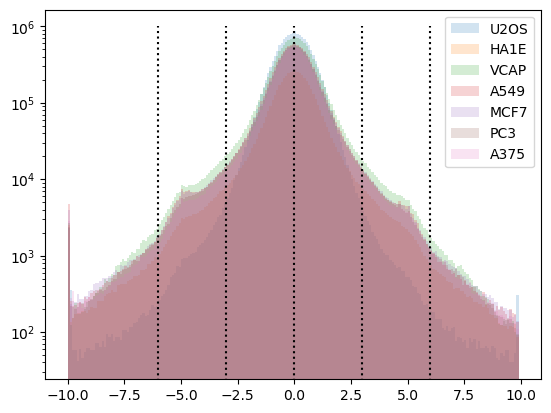

In [34]:
# Plot the distribution of activity values for each cell line
# We can observe that the distribution is Gaussian between -2.5 and 2.5 (a parabola in log-space).
# This indicates that the data is probably noise under this threshold.
for line, this_df in df_per_cell_line_cleaned.items():
    plt.hist(this_df[data_cols].values.flatten(), bins=np.arange(-10, 10, 0.1), alpha=0.2, log=True)
plt.legend(df_per_cell_line_cleaned.keys())
# plt.vlines([-THRESHOLD, 0, THRESHOLD], ymin=0, ymax=1e6, colors="black", linestyles=":")
plt.vlines([THRESHOLD_lst[0],THRESHOLD_lst[1], 0,THRESHOLD_lst[2], THRESHOLD_lst[3]], ymin=0, ymax=1e6, colors="black", linestyles=":")

In [ ]:
# Save each chosen cell-line into 2 CSV files. One with z-score, one with thresholded z-score
# single THRESHOLD
# Create the dirs
zscore_dir = f"{OUT_DIR}zscore-highestactivity/"
makedirs(zscore_dir, exist_ok=True)
class_dir = f"{OUT_DIR}classification-highestactivity/"
makedirs(class_dir, exist_ok=True)
class_dir2 = f"{OUT_DIR}classification-filtered/"
makedirs(class_dir2, exist_ok=True)


data_cols2 = ["geneID-" + str(col) for col in data_cols]
data_cols_rename = {data_cols[ii]: data_cols2[ii] for ii in range(len(data_cols))}
for line, this_df in df_per_cell_line_cleaned.items():
    this_df = this_df.rename(columns=data_cols_rename)
    this_df.to_csv(f"{zscore_dir}{line}.csv", index=False)
    this_df_classification = this_df.copy(deep=True)
    this_df_classification[data_cols2] = (np.abs(this_df_classification[data_cols2]) > THRESHOLD).astype(int)
    display(this_df_classification)
    this_df_classification.to_csv(f"{class_dir}{line}.csv", index=False)
    remove_cols = [col for col in data_cols2 if np.sum(this_df_classification[col]) < MIN_ACTIVE_PER_COL]
    this_df_class_filtered = this_df_classification.copy(deep=True).drop(columns=remove_cols)
    this_df_class_filtered.to_csv(f"{class_dir2}{line}.csv", index=False)
    vals = this_df_class_filtered[set(data_cols2) - set(remove_cols)].values
    print("{}:\tnum mols: {}; \tnum cols removed = {}; \tdensity of positives = {:.2%}\n".format(
    line, vals.shape[0], len(remove_cols), np.sum(vals) / np.size(vals)
    ))

In [36]:
def apply_labels(x):
  if x <= -6:
    return 0
  elif x<= -3 and x>-6:
   return 1
  elif x<= 3 and x>-3:
   return 2
  elif x<= 6 and x>3:
   return 3
  elif x>6:
   return 4

In [41]:
# Save each chosen cell-line into 2 CSV files. One with z-score, one with thresholded z-score

OUT_DIR = f"out/th_multi_label/"

# Create the dirs
zscore_dir = f"{OUT_DIR}zscore-highestactivity/"
makedirs(zscore_dir, exist_ok=True)
class_dir = f"{OUT_DIR}classification-highestactivity/"
makedirs(class_dir, exist_ok=True)
class_dir2 = f"{OUT_DIR}classification-filtered/"
makedirs(class_dir2, exist_ok=True)

modified_final_df = {}
data_cols2 = ["geneID-" + str(col) for col in data_cols]
data_cols_rename = {data_cols[ii]: data_cols2[ii] for ii in range(len(data_cols))}
for line, this_df in df_per_cell_line_cleaned.items():
    this_df = this_df.rename(columns=data_cols_rename)
    this_df.to_csv(f"{zscore_dir}{line}.csv", index=False)
    this_df_classification = this_df.copy(deep=True)
    this_df_classification[data_cols2] = this_df_classification[data_cols2].applymap(apply_labels)
    this_df_classification.to_csv(f"{class_dir}{line}.csv", index=False)
    # display(this_df_classification)
    modified_final_df[line] = this_df_classification
    remove_cols = [col for col in data_cols2 if np.sum(this_df_classification[col] != 2) < MIN_ACTIVE_PER_COL]
    print("removed columns", remove_cols)
    print("len of removed cols", len(remove_cols))
    this_df_class_filtered = this_df_classification.copy(deep=True).drop(columns=remove_cols)
    this_df_class_filtered.to_csv(f"{class_dir2}{line}.csv", index=False)
    vals = this_df_class_filtered[set(data_cols2) - set(remove_cols)].values
    print("{}:\tnum mols: {}; \tnum cols removed = {}; \tnum of 0's = {}; \tnum of 1's = {}; \tnum of 2's = {}; \tnum of 3's = {}; \tnum of 4's = {}\n".format(
    line, vals.shape[0], len(remove_cols),np.unique(vals,return_counts=True)[1][0],np.unique(vals,return_counts=True)[1][1],np.unique(vals,return_counts=True)[1][2],np.unique(vals,return_counts=True)[1][3],np.unique(vals,return_counts=True)[1][4])
    )

removed columns []
len of removed cols 0
U2OS:	num mols: 16058; 	num cols removed = 0; 	num of 0's = 6629; 	num of 1's = 44426; 	num of 2's = 15615576; 	num of 3's = 32878; 	num of 4's = 5215

removed columns ['geneID-9637']
len of removed cols 1
HA1E:	num mols: 5514; 	num cols removed = 1; 	num of 0's = 18531; 	num of 1's = 111277; 	num of 2's = 5146513; 	num of 3's = 97224; 	num of 4's = 13633

removed columns []
len of removed cols 0
VCAP:	num mols: 15220; 	num cols removed = 0; 	num of 0's = 34339; 	num of 1's = 280665; 	num of 2's = 14323559; 	num of 3's = 222288; 	num of 4's = 24309

removed columns []
len of removed cols 0
A549:	num mols: 12285; 	num cols removed = 0; 	num of 0's = 30445; 	num of 1's = 213422; 	num of 2's = 11584661; 	num of 3's = 165520; 	num of 4's = 20682

removed columns []
len of removed cols 0
MCF7:	num mols: 11622; 	num cols removed = 0; 	num of 0's = 31900; 	num of 1's = 213495; 	num of 2's = 10928761; 	num of 3's = 169375; 	num of 4's = 22785

removed c

In [42]:
for line, this_df in modified_final_df.items():
    print(line)
    print("shape of datafarme with duplicates:" , this_df.shape)
    modified_final_df[line] = this_df.drop_duplicates(subset='SMILES', keep="first")
    print("shape of datafarme sfter removing duplicates:" , modified_final_df[line].shape)
    print("-------------------------------")


U2OS
shape of datafarme with duplicates: (16058, 984)
shape of datafarme sfter removing duplicates: (16057, 984)
-------------------------------
HA1E
shape of datafarme with duplicates: (5514, 984)
shape of datafarme sfter removing duplicates: (5488, 984)
-------------------------------
VCAP
shape of datafarme with duplicates: (15220, 984)
shape of datafarme sfter removing duplicates: (15193, 984)
-------------------------------
A549
shape of datafarme with duplicates: (12285, 984)
shape of datafarme sfter removing duplicates: (12256, 984)
-------------------------------
MCF7
shape of datafarme with duplicates: (11622, 984)
shape of datafarme sfter removing duplicates: (11585, 984)
-------------------------------
PC3
shape of datafarme with duplicates: (11521, 984)
shape of datafarme sfter removing duplicates: (11485, 984)
-------------------------------
A375
shape of datafarme with duplicates: (10694, 984)
shape of datafarme sfter removing duplicates: (10680, 984)
--------------------

In [44]:
import functools as ft
dfs = [this_df for line, this_df in modified_final_df.items()]
df_final = ft.reduce(lambda left, right: pd.merge(left, right, on='SMILES'), dfs)
common_smiles = df_final['SMILES']
print(len(common_smiles))

1450


In [45]:
lst_numbers = []
for check_df in dfs: 
    modified_1  = check_df.loc[check_df['SMILES'].isin(common_smiles)]
    numbers = modified_1[data_cols2]
    values_gene_id = np.reshape(numbers.values, (1,numbers.shape[0]*numbers.shape[1]))
    lst_numbers.append(values_gene_id)
df_corr = pd.DataFrame(np.concatenate(lst_numbers))
df_corr

,0,1,2,3,4,5,6,7,8,9,...,1418090,1418091,1418092,1418093,1418094,1418095,1418096,1418097,1418098,1418099
0,2,2,2,2,2,2,2,2,2,2,...,3,4,2,0,1,0,1,0,0,2
1,2,2,2,2,2,2,2,2,2,2,...,3,2,2,2,0,0,2,1,0,2
2,2,2,2,2,2,2,2,2,2,2,...,0,2,2,4,2,2,2,2,1,2
3,2,2,2,2,2,2,2,2,2,2,...,1,2,2,2,1,0,3,0,0,2
4,2,2,2,2,2,2,2,2,2,2,...,2,3,2,0,2,1,4,3,2,4
5,2,2,2,2,2,2,2,2,2,2,...,2,2,2,1,0,0,2,2,2,3
6,2,2,2,2,2,2,2,2,2,2,...,2,0,1,1,2,0,3,3,2,2


In [46]:
df_transpose = df_corr.transpose()
df_transpose.columns = df_transpose.columns.astype(str)
df_transpose = df_transpose.rename(columns={'0': 'U2OS', '1': 'HA1E','2': 'VCAP', '3': 'A549','4': 'MCF7', '5': 'PC3','6': 'A375' })
df_transpose.columns
corr_values = df_transpose.corr()
corr_values

,U2OS,HA1E,VCAP,A549,MCF7,PC3,A375
U2OS,1.000000,0.060399,0.061331,0.042867,0.060538,0.062246,0.061650
HA1E,0.060399,1.000000,0.079837,0.083084,0.082264,0.097515,0.102486
VCAP,0.061331,0.079837,1.000000,0.090002,0.090035,0.092994,0.099552
A549,0.042867,0.083084,0.090002,1.000000,0.079212,0.100671,0.104961
MCF7,0.060538,0.082264,0.090035,0.079212,1.000000,0.090312,0.086981
PC3,0.062246,0.097515,0.092994,0.100671,0.090312,1.000000,0.115805
A375,0.061650,0.102486,0.099552,0.104961,0.086981,0.115805,1.000000


<Axes: >

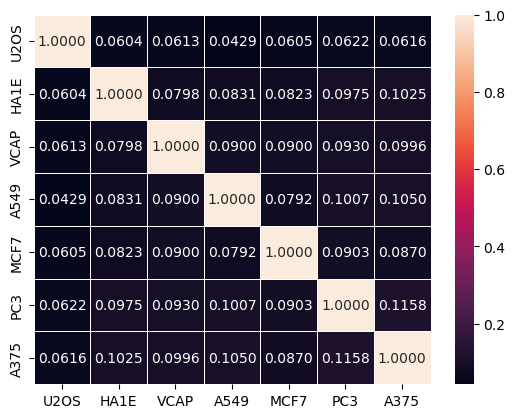

In [47]:
import seaborn as sns
sns.heatmap(corr_values, annot= True,linewidth=.5, fmt=".4f")